In [3]:
!pip install lightkurve
!pip install tsfresh -c constraints.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 26.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.1 which is incompatible.
  Using cached tsfresh-0.20.3-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached stumpy-1.13.0-py3-none-any.whl.metadata (28 kB)
  Using cached scipy-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached tsfresh-0.20.3-py2.py3-none-any.whl (95 kB)
Using cached scipy-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.1 MB)
Using cached stumpy-1.13.0-py3-none-any.whl (176 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.1
    Uninstalling scipy-1.15.1:
      Successfully uninst

In [4]:
#uploading star ID file for light curve extraction
from google.colab import files

# Prompt user to upload files
uploaded = files.upload()

# Safely extract filenames and print feedback
if uploaded:
    filename = next(iter(uploaded))
    print(f"File '{filename}' uploaded successfully.")
else:
    print("No files uploaded.")

Saving labelled_training_star_data_processed.csv to labelled_training_star_data_processed.csv
File 'labelled_training_star_data_processed.csv' uploaded successfully.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from lightkurve import search_targetpixelfile
from tsfresh import extract_features
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from csv import writer
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
data = pd.read_csv(filename)

# Making sure to drop duplicates
data.drop_duplicates(subset=['Star_ID'], inplace=True)
data = data.dropna(axis=1, how='all')
data

,Star_ID,Stellar Effective Temperature (Kelvin),Stellar Effective Radius (solar radii),Exoplanet_Actual
0,TIC 139118482,6179.1,1.15000,0
1,TIC 80029842,6536.0,1.15000,0
2,TIC 108939482,6325.0,1.15885,0
3,TIC 124379043,6384.0,1.16000,1
4,TIC 387603144,6223.0,1.16000,0
...,...,...,...,...
443,TIC 300038935,8208.0,1.80000,1
444,TIC 395171208,6696.0,1.80000,1
445,TIC 155005217,9139.0,1.80000,0
446,TIC 285674856,8348.0,1.80000,0


In [ ]:
# @title Manual Feature Extraction
# Importing required libraries
from lightkurve import search_lightcurvefile
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Feature extraction function
def extract_features_from_lightcurve(lc):
    """Extracts features from a LightCurve object."""
    flux = lc.flux.value  # Extract flux values
    time = lc.time.value  # Extract time value's

    # Handle missing or invalid values
    flux = flux[~np.isnan(flux)]
    time = time[~np.isnan(time)]

    # Compute basic features
    features = {
        "mean_flux": np.mean(flux),
        "median_flux": np.median(flux),
        "std_flux": np.std(flux),
        "min_flux": np.min(flux),
        "max_flux": np.max(flux),
        "range_flux": np.ptp(flux),
        "skew_flux": skew(flux),
        "kurtosis_flux": kurtosis(flux),
        "flux_variation": np.var(flux),
        "time_duration": np.ptp(time),
        "flux_diff": np.max(flux) - np.min(flux),  # Max-Min difference
        "flux_variability_index": np.std(flux) / np.mean(flux),  # Variability index
    }
    return features

# Main function for processing light curves
def process_lightcurves(input_file, output_file="lightcurve_features.csv"):
    extracted_data = []

    # Read the input CSV file
    with open(input_file, encoding='utf-8') as file:
        reader = pd.read_csv(file)

        for _, row in reader.iterrows():

            try:
                # Search and download the light curve file
                lc_file = search_lightcurvefile(row['Star_ID']).download(quality_bitmask='default')
                if lc_file is None:
                    print(f"No light curve found for ID: {row['Star_ID']}")
                    continue

                # Extract the PDCSAP_FLUX light curve
                lc = lc_file.PDCSAP_FLUX
                features = extract_features_from_lightcurve(lc)

                # Add metadata
                features["Star_ID"] = row['Star_ID']
                features["Exoplanet_Actual"] = row['Exoplanet_Actual']

                # Append to results
                extracted_data.append(features)

            except Exception as e:
                print(f"Error processing ID {row['Star_ID']}: {e}")
                continue

    # Create a DataFrame for all extracted features
    if extracted_data:
        feature_df = pd.DataFrame(extracted_data)
        feature_df.to_csv(output_file, index=False)
        print(f"Feature extraction complete. Results saved to {output_file}.")
    else:
        print("No features extracted. Check the input data.")

# Run the processing function
process_lightcurves(filename)

In [ ]:
# @title Creating DataFrame of the feature file with manually extracted features
data = pd.read_csv('/content/lightcurve_features.csv')
data

In [ ]:
# @title ML model on manually extracted features

# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Step 1: Load the feature file
feature_file = "lightcurve_features.csv"  # Replace with your file name
data = pd.read_csv(feature_file)

# Step 2: Data Preparation
# Separate features (X) and target (y)
X = data.drop(columns=["Exoplanet_Actual", "Star_ID"])  # Drop target and metadata

# Explicitly handle NaN in the target column 'Boolean'
data['Exoplanet_Actual'] = data['Exoplanet_Actual'].fillna('1')  # Treat NaN as "No"

# Assign the processed 'Exoplanet_Actual' column to y
y = data['Exoplanet_Actual'].astype(float) # Convert to numerical data type for the model

# Ensure no NaN values in y after mapping
if y.isnull().any():
    print("Warning: NaN values still present in 'y'. Replacing with 0.")
    y = y.fillna(0)

# Handle missing values in features
X = X.fillna(X.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Build the Neural Network
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.4),  # Increased dropout rate
#     Dense(64, activation='relu'),
#     Dropout(0.4),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(optimizer='adamw',  # Consider reducing learning rate if necessary
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the Model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=30,
                    verbose=1,
                    callbacks=[early_stopping])

# Step 6: Evaluate the Model
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Handle any potential NaN in y_test (just for safety)
y_test = np.nan_to_num(y_test)

print("\nAccuracy:", np.mean(y_pred == y_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 7: Visualize Training History
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [7]:
import logging
logging.getLogger("tsfresh.feature_extraction.settings").setLevel(logging.ERROR)

In [8]:
from lightkurve import search_targetpixelfile
from tsfresh import extract_features
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from csv import writer
appended_data = []
with open(filename) as file:
    reader = csv.DictReader(file)

    for row in reader:
      try:
          tpf_file = search_targetpixelfile(row['Star_ID']).download(quality_bitmask='default')
          if tpf_file == None:
            continue
          lc = tpf_file.to_lightcurve()
          lc.to_csv("light_curve_features.csv", overwrite = True)
          df = pd.read_csv("light_curve_features.csv")
          df["ID"] = 1
          extracted_features = extract_features(df, default_fc_parameters=MinimalFCParameters(), column_id = "ID")
          extracted_features['Exoplanet_Actual'] = row['Exoplanet_Actual']
          extracted_features.insert(loc = 0, column = "Star_ID", value = row['Star_ID'])
          appended_data.append(extracted_features)


      except (TypeError , AttributeError, ValueError):
          continue



Feature Extraction: 100%|██████████| 7/7 [00:00<00:00, 712.80it/s]


In [9]:
#appending data to a single file
appended_data = pd.concat(appended_data)
appended_data

,Star_ID,time__sum_values,time__median,time__mean,time__length,time__standard_deviation,time__variance,time__root_mean_square,time__maximum,time__absolute_maximum,...,quality__median,quality__mean,quality__length,quality__standard_deviation,quality__variance,quality__root_mean_square,quality__maximum,quality__absolute_maximum,quality__minimum,Exoplanet_Actual
1,TIC 108939482,5.288332e+07,2975.573660,2975.486554,17773.0,7.390583,54.620717,2975.495733,2988.228998,2988.228998,...,0.0,468.072695,17773.0,1303.117548,1.698115e+06,1384.632584,4096.0,4096.0,0.0,0
1,TIC 387603144,2.031333e+06,1723.793275,1724.391728,1178.0,7.698893,59.272946,1724.408915,1737.387257,1737.387257,...,0.0,6533.432937,1178.0,12942.707835,1.675137e+08,14498.256172,32768.0,32768.0,0.0,0
1,TIC 366989877,3.243120e+07,1668.639277,1668.186015,19441.0,8.369620,70.050533,1668.207011,1682.361562,1682.361562,...,0.0,933.853197,19441.0,2603.431360,6.777855e+06,2765.851883,8704.0,8704.0,0.0,1
1,TIC 159334269,4.978917e+07,2621.291006,2622.000541,18989.0,8.303083,68.941195,2622.013687,2635.986595,2635.986595,...,0.0,730.157460,18989.0,1567.671853,2.457595e+06,1729.371260,4096.0,4096.0,0.0,0
1,TIC 420814525,3.341413e+08,2839.311774,2839.212840,117688.0,8.094373,65.518871,2839.224379,2853.143860,2853.143860,...,0.0,19.986677,117688.0,139.147177,1.936194e+04,140.575261,1600.0,1600.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,TIC 300038935,2.173232e+07,1479.807907,1479.295100,14691.0,6.444847,41.536052,1479.309139,1490.044141,1490.044141,...,0.0,163.881560,14691.0,2131.830595,4.544702e+06,2138.120401,32768.0,32768.0,0.0,1
1,TIC 395171208,3.341411e+08,2839.310011,2839.211093,117688.0,8.094544,65.521649,2839.222632,2853.142439,2853.142439,...,0.0,18.336211,117688.0,132.266556,1.749444e+04,133.531488,1600.0,1600.0,0.0,1
1,TIC 155005217,5.568262e+07,2839.310889,2839.211745,19612.0,8.094409,65.519451,2839.223283,2853.142242,2853.142242,...,0.0,149.355089,19612.0,767.696512,5.893579e+05,782.090070,4096.0,4096.0,0.0,0
1,TIC 285674856,1.952544e+06,1802.369753,1802.902877,1083.0,7.118382,50.671355,1802.916929,1815.015680,1815.015680,...,0.0,1667.900277,1083.0,6695.017955,4.482327e+07,6899.649031,32768.0,32768.0,0.0,0


In [10]:
# Removing any columns in the dataset with all 0 values
appended_data = appended_data.loc[:, (appended_data != 0).any(axis=0)]

appended_data

,Star_ID,time__sum_values,time__median,time__mean,time__length,time__standard_deviation,time__variance,time__root_mean_square,time__maximum,time__absolute_maximum,...,cadenceno__minimum,quality__sum_values,quality__mean,quality__length,quality__standard_deviation,quality__variance,quality__root_mean_square,quality__maximum,quality__absolute_maximum,Exoplanet_Actual
1,TIC 108939482,5.288332e+07,2975.573660,2975.486554,17773.0,7.390583,54.620717,2975.495733,2988.228998,2988.228998,...,1249448.0,8319056.0,468.072695,17773.0,1303.117548,1.698115e+06,1384.632584,4096.0,4096.0,0
1,TIC 387603144,2.031333e+06,1723.793275,1724.391728,1178.0,7.698893,59.272946,1724.408915,1737.387257,1737.387257,...,23229.0,7696384.0,6533.432937,1178.0,12942.707835,1.675137e+08,14498.256172,32768.0,32768.0,0
1,TIC 366989877,3.243120e+07,1668.639277,1668.186015,19441.0,8.369620,70.050533,1668.207011,1682.361562,1682.361562,...,307055.0,18155040.0,933.853197,19441.0,2603.431360,6.777855e+06,2765.851883,8704.0,8704.0,1
1,TIC 159334269,4.978917e+07,2621.291006,2622.000541,18989.0,8.303083,68.941195,2622.013687,2635.986595,2635.986595,...,993946.0,13864960.0,730.157460,18989.0,1567.671853,2.457595e+06,1729.371260,4096.0,4096.0,0
1,TIC 420814525,3.341413e+08,2839.311774,2839.212840,117688.0,8.094373,65.518871,2839.224379,2853.143860,2853.143860,...,6902508.0,2352192.0,19.986677,117688.0,139.147177,1.936194e+04,140.575261,1600.0,1600.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,TIC 300038935,2.173232e+07,1479.807907,1479.295100,14691.0,6.444847,41.536052,1479.309139,1490.044141,1490.044141,...,173388.0,2407584.0,163.881560,14691.0,2131.830595,4.544702e+06,2138.120401,32768.0,32768.0,1
1,TIC 395171208,3.341411e+08,2839.310011,2839.211093,117688.0,8.094544,65.521649,2839.222632,2853.142439,2853.142439,...,6902508.0,2157952.0,18.336211,117688.0,132.266556,1.749444e+04,133.531488,1600.0,1600.0,1
1,TIC 155005217,5.568262e+07,2839.310889,2839.211745,19612.0,8.094409,65.519451,2839.223283,2853.142242,2853.142242,...,1150418.0,2929152.0,149.355089,19612.0,767.696512,5.893579e+05,782.090070,4096.0,4096.0,0
1,TIC 285674856,1.952544e+06,1802.369753,1802.902877,1083.0,7.118382,50.671355,1802.916929,1815.015680,1815.015680,...,27035.0,1806336.0,1667.900277,1083.0,6695.017955,4.482327e+07,6899.649031,32768.0,32768.0,0


In [11]:
appended_data.to_csv("final_train_file.csv")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.4769 - loss: 0.8413 - val_accuracy: 0.6102 - val_loss: 0.6872
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5878 - loss: 0.6891 - val_accuracy: 0.5593 - val_loss: 0.6717
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5675 - loss: 0.7101 - val_accuracy: 0.5763 - val_loss: 0.6637
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6722 - loss: 0.6203 - val_accuracy: 0.5932 - val_loss: 0.6567
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6281 - loss: 0.6194 - val_accuracy: 0.6102 - val_loss: 0.6537
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7081 - loss: 0.5876 - val_accuracy: 0.6102 - val_loss: 0.6516
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6924 - loss: 0.5533 - val_accuracy: 0.6102 - val_loss: 0.6453
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6433 - loss: 0.6032 - val_accuracy: 0.5932 - val_loss: 0.644

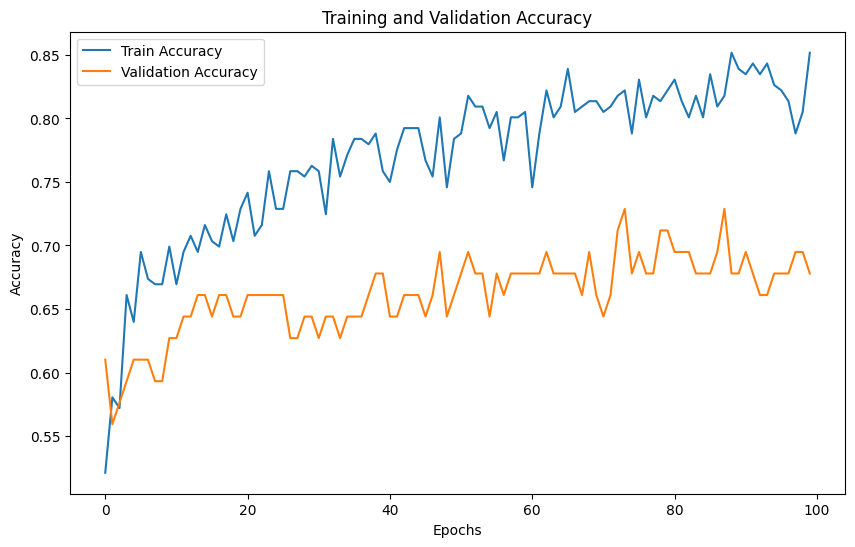

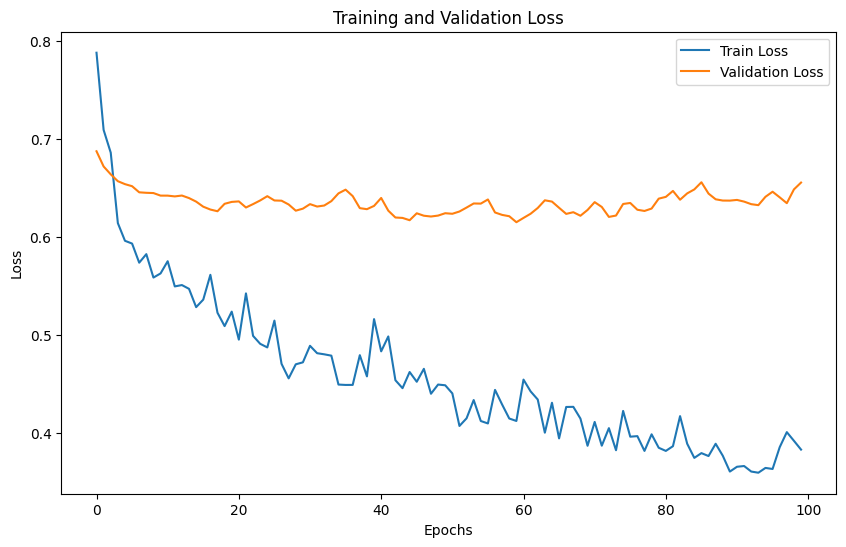

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt

# Step 1: Load data from CSV
file_path = "final_train_file.csv"  # Path to your CSV file
data = pd.read_csv(file_path)

# Step 2: Prepare the data
# Separate features and target
X = data.drop(columns=["Unnamed: 0", "Star_ID", "Exoplanet_Actual"])  # Drop unnecessary columns
y = data["Exoplanet_Actual"]  # Target column

# Handle missing values (if any)
X = X.fillna(X.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Build the Neural Network
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

# Step 5: Evaluate the model
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 6: Visualize Training History
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
print(y.value_counts())

Exoplanet_Actual
0    160
1    135
Name: count, dtype: int64
